<a href="https://colab.research.google.com/github/nirb28/ee-predict/blob/main/large/eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [53]:
# importing modules and packages
import pandas as pd
import numpy as np, os

# import libraries for plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
pd.set_option('display.max_columns', 200)

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [54]:
# Import the dataset from the csv file.
if os.path.exists('/content/drive'):
  df = pd.read_csv('/content/drive/MyDrive/work/gdrive-workspaces/git/ee-predict/data/large_cat_desc_col_names.csv')
else:
  df = pd.read_csv('../data/large_cat_desc_col_names.csv')


In [55]:
df.columns #= [*df.columns[:-1], 'ddG']
#df.head()

Index(['Identifier', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '3965', '3966', '3967', '3968', '3969', '3970', '3971', '3972', '3973',
       'ddG'],
      dtype='object', length=3975)

In [56]:
df.shape
# This is a problem as our n << p
# And if p > n, then there is no longer a unique least squares coefficient estimate.
# Least squares will not be a

(1903, 3975)

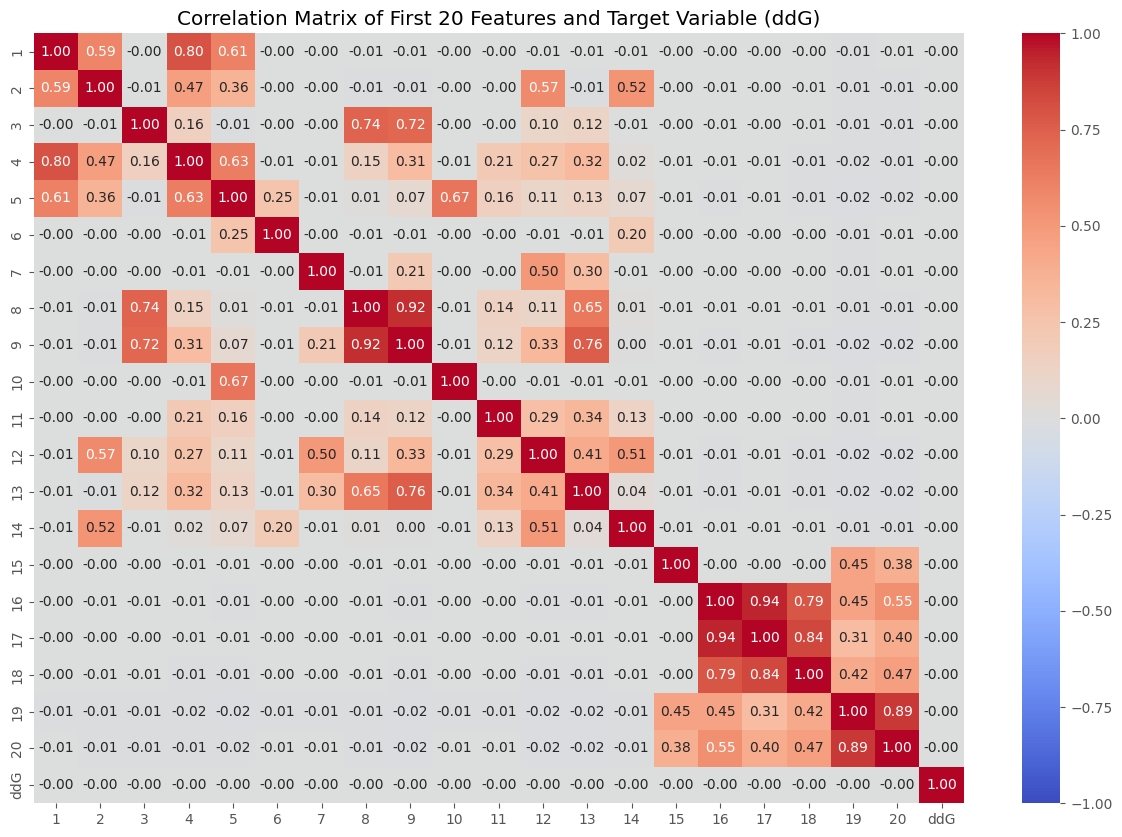

In [57]:
# Compute the correlation matrix for the first 20 features and the target variable to keep it manageable
correlation_matrix = df.iloc[:, 1:21].join(df['ddG']).corr()

# Plot the correlation matrix
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix of First 20 Features and Target Variable (ddG)")
plt.show()

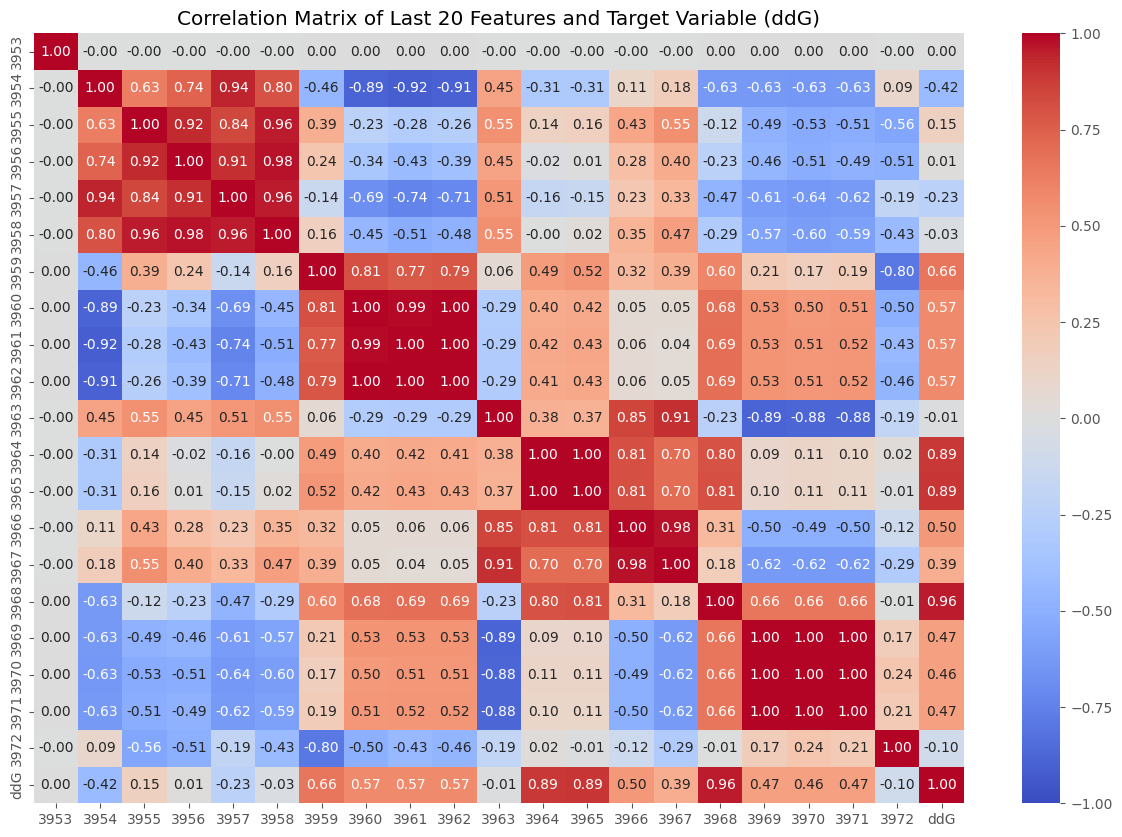

In [58]:
# Compute the correlation matrix for the last 20 features and the target variable to keep it manageable
correlation_matrix = df.iloc[:, 3953:3973].join(df['ddG']).corr()

# Plot the correlation matrix
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix of Last 20 Features and Target Variable (ddG)")
plt.show()

In [59]:
corr_table = df[df.iloc[:, 1:3974].columns].corrwith(df['ddG'])
corr_table

1      -0.000086
2      -0.000120
3      -0.000112
4      -0.000155
5      -0.000171
          ...   
3969    0.466042
3970    0.464271
3971    0.465601
3972   -0.099649
3973    0.600778
Length: 3973, dtype: float64

In [60]:
# prompt: find rows in corr_table where corr > .4
high_corr_rows = corr_table[abs(corr_table) > .01]
print(high_corr_rows)
print(high_corr_rows.keys())

3954   -0.424288
3955    0.150541
3957   -0.227592
3958   -0.027907
3959    0.657974
3960    0.571916
3961    0.572095
3962    0.573375
3963   -0.014249
3964    0.885165
3965    0.893364
3966    0.500519
3967    0.393234
3968    0.958238
3969    0.466042
3970    0.464271
3971    0.465601
3972   -0.099649
3973    0.600778
dtype: float64
Index(['3954', '3955', '3957', '3958', '3959', '3960', '3961', '3962', '3963',
       '3964', '3965', '3966', '3967', '3968', '3969', '3970', '3971', '3972',
       '3973'],
      dtype='object')


## Subset Selection Methods
Here we implement methods that reduce the number of parameters

### Forward Selection
We will  apply the forward-selection approach


In [ ]:
!pip install ISLP
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from statsmodels.api import OLS
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from functools import partial

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from ISLP.models import \
     (Stepwise,
      sklearn_selected,
      sklearn_selection_path)

0

In [ ]:
def nCp(sigma2, estimator, X, Y):
    "Negative Cp statistic"
    n, p = X.shape
    Yhat = estimator.predict(X)
    RSS = np.sum((Y - Yhat)**2)
    return -(RSS + 2 * p * sigma2) / n

In [ ]:
df_cleaned.head()

,1,2,3,4,5,6,7,8,9,10,...,3965,3966,3967,3968,3969,3970,3971,3972,3973,ddG
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.833714,-0.605952,-0.471700,-0.768480,-0.178536,-0.298590,-0.238640,-0.277510,-0.230633,-0.672194
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.880495,-0.602624,-0.471616,-0.798242,-0.277709,-0.280445,-0.279338,-0.246094,-1.153164,-1.146684
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.104378,1.789966,1.707972,-0.078629,-1.416062,-1.347984,-1.383415,0.492188,0.691898,0.276786
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.938972,-0.643031,-0.505083,-0.825677,-0.297732,-0.236059,-0.267225,0.028798,-0.691898,-0.672194
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.112732,0.601039,0.691527,1.360684,0.614598,0.524781,0.570340,-1.518452,-0.230633,1.463011


We first choose the best model using forward selection based on $C_p$. We define a function to compute it as its not built in as a metric to `sklearn`. By default, `sklearn` tries to maximize a score, hence
  our scoring function  computes the negative $C_p$ statistic.

In [ ]:
def nCp(sigma2, estimator, X, Y):
    "Negative Cp statistic"
    n, p = X.shape
    Yhat = estimator.predict(X)
    RSS = np.sum((Y - Yhat)**2)
    return -(RSS + 2 * p * sigma2) / n


In [ ]:
design = MS(df_cleaned.columns.drop('ddG')).fit(df_cleaned)
Y = np.array(df_cleaned['ddG'])
X = design.transform(df_cleaned)
sigma2 = OLS(Y,X).fit().scale

In [ ]:
neg_Cp = partial(nCp, sigma2)

We can now use `neg_Cp()` as a scorer for model selection.

Along with a score we need to specify the search strategy. This is done through the object
`Stepwise()`  in the `ISLP.models` package. The method `Stepwise.first_peak()`
runs forward stepwise until any further additions to the model do not result
in an improvement in the evaluation score. Similarly, the method `Stepwise.fixed_steps()`
runs a fixed number of steps of stepwise search.

In [ ]:
strategy = Stepwise.first_peak(design,
                               direction='forward',
                               max_terms=len(design.terms))


We now fit a linear regression model with `Salary` as outcome using forward
selection. To do so, we use the function `sklearn_selected()`  from the `ISLP.models` package. This takes
a model from `statsmodels` along with a search strategy and selects a model with its
`fit` method. Without specifying a `scoring` argument, the score defaults to MSE, and so all 19 variables will be
selected.

In [ ]:
hitters_MSE = sklearn_selected(OLS,
                               strategy)
hitters_MSE.fit(df_cleaned, Y)
hitters_MSE.selected_state_


('3954', '3955', '3964', '3968', '3970')

Using `neg_Cp` results in a smaller model, as expected, with just 10 variables selected.

In [ ]:
hitters_Cp = sklearn_selected(OLS,
                               strategy,
                               scoring=neg_Cp)
hitters_Cp.fit(df_cleaned, Y)
hitters_Cp.selected_state_


('2595', '3489', '3955', '3960', '3964', '3968', '3970')

### Choosing Among Models Using the Validation Set Approach and Cross-Validation

As an  alternative to using $C_p$, we might try cross-validation to select a model in forward selection. For this, we need a
method that stores the full path of models found in forward selection, and allows predictions for each of these. This can be done with the `sklearn_selection_path()`
estimator from `ISLP.models`. The function `cross_val_predict()` from `ISLP.models`
computes the cross-validated predictions for each of the models
along the path, which we can use to evaluate the cross-validated MSE
along the path.

Here we define a strategy that fits the full forward selection path.
While there are various parameter choices for `sklearn_selection_path()`,
we use the defaults here, which selects the model at each step based on the biggest reduction  in RSS.

In [ ]:
strategy = Stepwise.fixed_steps(design,
                                len(design.terms),
                                direction='forward')
full_path = sklearn_selection_path(OLS, strategy)


We now fit the full forward-selection path on the `Hitters` data and compute the fitted values.

In [ ]:
full_path.fit(df_cleaned, Y)
Yhat_in = full_path.predict(df_cleaned)
Yhat_in.shape


This gives us an array of fitted values --- 20 steps in all, including the fitted mean for the null model --- which we can use to evaluate
in-sample MSE. As expected, the in-sample MSE improves each step we take,
indicating we must use either the validation or cross-validation
approach to select the number of steps. We fix the y-axis to range from
50,000 to 250,000 to compare to the cross-validation and validation
set MSE below, as well as other methods such as ridge regression, lasso and
principal components regression.

In [ ]:
mse_fig, ax = subplots(figsize=(8,8))
insample_mse = ((Yhat_in - Y[:,None])**2).mean(0)
n_steps = insample_mse.shape[0]
ax.plot(np.arange(n_steps),
        insample_mse,
        'k', # color black
        label='In-sample')
ax.set_ylabel('MSE',
              fontsize=20)
ax.set_xlabel('# steps of forward stepwise',
              fontsize=20)
ax.set_xticks(np.arange(n_steps)[::2])
ax.legend()
ax.set_ylim([50000,250000]);


from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from ISLP.models import \
     (Stepwise,
      sklearn_selected,
      sklearn_selection_path)

## PCA
Here we implement methods that reduce the number of parameters


In [70]:
X = df[high_corr_rows.keys()]
y = df['ddG']

Logistic Regression model with all features

In [71]:
from sklearn.decomposition import PCA
pca = PCA()
X_pca = pca.fit_transform(X_std)
print(pca.explained_variance_ratio_)

cumsum = np.cumsum(pca.explained_variance_ratio_)
dim = np.argmax(cumsum >= 0.90) + 1
print('The number of dimensions required to preserve 90% of variance is', dim)

[4.50095200e-01 2.94539193e-01 1.60838841e-01 9.18422737e-02
 2.68449196e-03 2.24306254e-30 8.90972888e-31 6.38236954e-31
 5.27743462e-31 3.54274618e-31 8.14545346e-34 1.02865063e-35
 5.85800846e-36 2.27048845e-36 1.35717285e-36 7.86635435e-37
 8.77464652e-38 6.73367565e-38 1.81277094e-38]
The number of dimensions required to preserve 90% of variance is 3


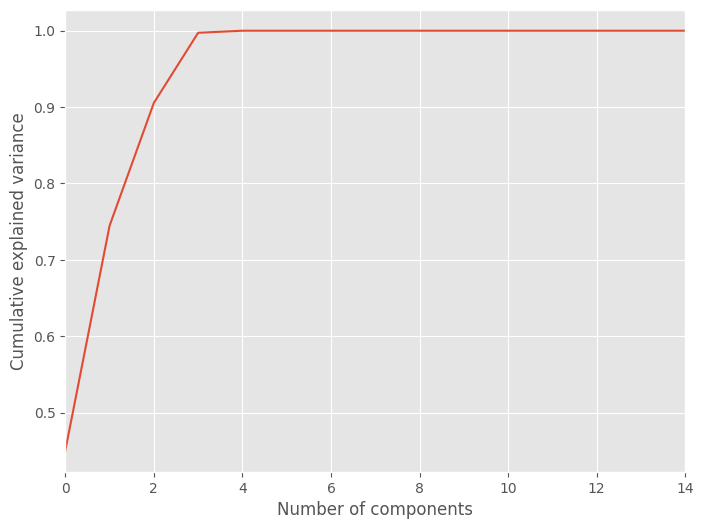

In [72]:
plt.figure(figsize=(8,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,14,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

In [64]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_std)
print(pca.explained_variance_ratio_)

[0.4499394  0.29502477 0.16054692]


In [65]:
df_pca = pd.DataFrame(X_pca,columns=['PCA1','PCA2','PCA3']) #,'PCA4','PCA5','PCA6','PCA7','PCA8','PCA9','PCA10','PCA11','PCA12','PCA13'])
df_pca['ddG'] = df['ddG']

In [66]:
X_train,X_test,y_train,y_test = train_test_split(X_pca,y,test_size=0.2)
for i in [X_train,X_test,y_train,y_test]:
    print("Shape of Data is {}".format(i.shape))

Shape of Data is (1522, 3)
Shape of Data is (381, 3)
Shape of Data is (1522,)
Shape of Data is (381,)


In [67]:
# import libraires needed to perform our Regression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
# Lets train our model on training data and predict also on training to see results
lr = LinearRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_train)
r2 = r2_score(y_train,y_pred)
rmse = np.sqrt(mean_squared_error(y_train,y_pred))
print('R-Squared Score is : {} | Root Mean Square Error is : {}'.format(r2,rmse))

R-Squared Score is : 0.8530132621394736 | Root Mean Square Error is : 0.35158968382978945


In [68]:
# Lets train our model on training data and predict on testing to see results
lr = LinearRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
r2 = r2_score(y_test,y_pred)
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print('R2 Score is : {} | Root Mean Square Error is : {}'.format(r2,rmse))

R2 Score is : 0.8480979597265534 | Root Mean Square Error is : 0.3515139103905348
